# Training Deep Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
plt.rc("font", size=14)
plt.rc("axes", titlesize=14, labelsize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

## Vanishing and Exploding Gradients

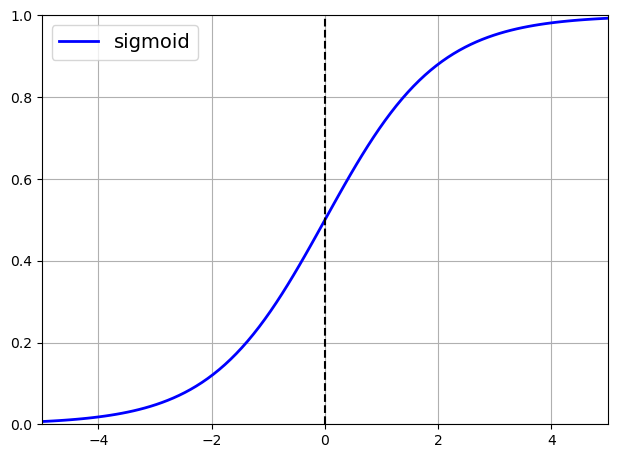

In [11]:
z = np.linspace(-5, 5, 100)

def sigmoid(z):
    return  1 / (1 + np.exp(-z))

plt.plot(z, sigmoid(z), "b-", linewidth=2, label="sigmoid")
plt.axvline(0, color="black", linestyle="--")
plt.axis([-5, 5, 0, 1])
plt.grid(True)
plt.tight_layout()
plt.legend()

As you can see the line gets saturated at two points in sigmoid activation function

### Xavier and He Initilization

In [13]:
dense = Dense(30, activation="relu", kernel_initializer="he_normal")

In [14]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2, mode="fan_avg", distribution="uniform")
dense2 = Dense(30, activation="relu", kernel_initializer=he_avg_init)

### Non Saturating Activation Functions

#### Leaky Relu

In [17]:
def leaky_relu(z, alpha):
    return np.maximum(z * alpha, z)

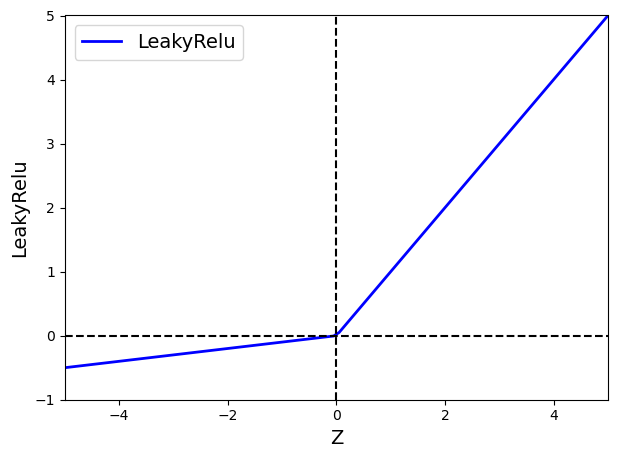

In [19]:
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label="LeakyRelu")
plt.axvline(0, color="black", linestyle="--")
plt.axhline(0, color="black", linestyle="--")

plt.xlabel("Z")
plt.ylabel("LeakyRelu")
plt.axis([-5, 5, -1, 5])
plt.tight_layout()
plt.legend()

In [20]:
leky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) #defaults to 0.3

In [21]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

#### ELU (Exponiantial Linear Unit)

In [22]:
dense = Dense(30, activation="elu", kernel_initializer="he_normal")

#### SELU (Scaled Exponinatial Linear Unit)

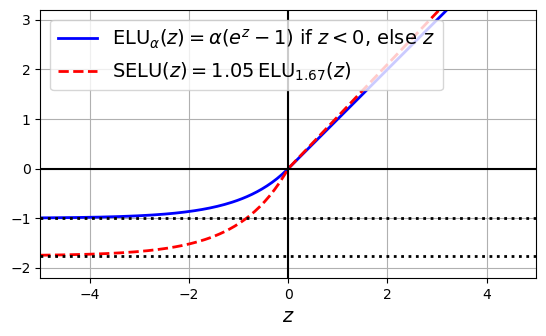

In [25]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend(loc="upper left")

plt.show()

In [26]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

In [27]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


1719/1719 [==============================] - 26s 12ms/step - loss: 1.0740 - accuracy: 0.5913 - val_loss: 0.7633 - val_accuracy: 0.7246
Epoch 2/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6918 - accuracy: 0.7495 - val_loss: 0.6359 - val_accuracy: 0.7652
Epoch 3/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.5943 - accuracy: 0.7883 - val_loss: 0.5748 - val_accuracy: 0.7972
Epoch 4/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.5375 - accuracy: 0.8123 - val_loss: 0.4955 - val_accuracy: 0.8294
Epoch 5/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.5053 - accuracy: 0.8252 - val_loss: 0.5584 - val_accuracy: 0.8094


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [35]:
model = Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for i in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [36]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

In [37]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
1719/1719 [==============================] - 35s 13ms/step - loss: 2.3037 - sparse_categorical_accuracy: 0.1007 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0980
Epoch 2/5
1719/1719 [==============================] - 19s 11ms/step - loss: 2.3029 - sparse_categorical_accuracy: 0.0981 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1054
Epoch 3/5
1719/1719 [==============================] - 18s 10ms/step - loss: 2.3028 - sparse_categorical_accuracy: 0.0991 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0934
Epoch 4/5
1719/1719 [==============================] - 18s 10ms/step - loss: 2.3028 - sparse_categorical_accuracy: 0.0991 - val_loss: 2.3025 - val_sparse_categorical_accuracy: 0.1016
Epoch 5/5
1719/1719 [==============================] - 18s 11ms/step - loss: 2.3028 - sparse_categorical_accuracy: 0.0988 - val_loss: 2.3029 - val_sparse_categorical_accuracy: 0.1006


The relu activation function suffers from the exploding gradient problem

#### GELU (Gaussian Error Linear Unit), SWISH and MISH

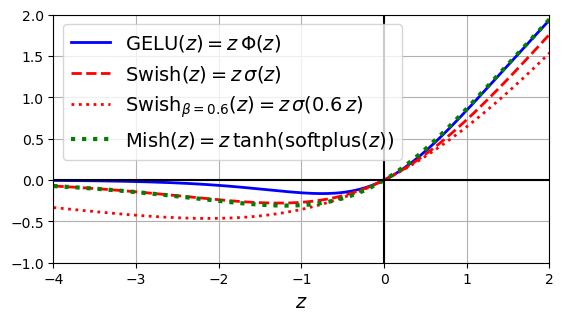

In [38]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

### Batch Normalization

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [13]:
model = Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.BatchNormalization(),
        Dense(300, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        Dense(10, activation="softmax")
    ]
)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 784)               3136      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_4 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_5 (Bat  (None, 100)              

In [15]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

In [16]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

In [17]:
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30


1719/1719 [==============================] - 6s 3ms/step - loss: 0.4734 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.3652 - val_sparse_categorical_accuracy: 0.8622
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3610 - sparse_categorical_accuracy: 0.8678 - val_loss: 0.3609 - val_sparse_categorical_accuracy: 0.8638
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3280 - sparse_categorical_accuracy: 0.8789 - val_loss: 0.3323 - val_sparse_categorical_accuracy: 0.8832
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2999 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.8822
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2819 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.2974 - val_sparse_categorical_accuracy: 0.8876
Epoch 6/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2652 - spa

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))


Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6063 - accuracy: 0.7980 - val_loss: 0.4318 - val_accuracy: 0.8472
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4266 - accuracy: 0.8507 - val_loss: 0.3728 - val_accuracy: 0.8658


### Gradient Clippint

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [24]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [25]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

### Reusing a pretrained model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [26]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 2s 1ms/step - loss: 1.3078 - accuracy: 0.6011 - val_loss: 0.7915 - val_accuracy: 0.7814
Epoch 2/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.6557 - accuracy: 0.8022 - val_loss: 0.5402 - val_accuracy: 0.8366
Epoch 3/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.5026 - accuracy: 0.8465 - val_loss: 0.4487 - val_accuracy: 0.8549
Epoch 4/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.4317 - accuracy: 0.8643 - val_loss: 0.3978 - val_accuracy: 0.8679
Epoch 5/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3904 - accuracy: 0.8738 - val_loss: 0.3692 - val_accuracy: 0.8747
Epoch 6/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3629 - accuracy: 0.8808 - val_loss: 0.3477 - val_accuracy: 0.8822
Epoch 7/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3436 - accuracy: 0.8853 - val_loss: 0.3332 - val_accuracy:

INFO:tensorflow:Assets written to: my_model_A\assets


In [27]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 29ms/step - loss: 0.6738 - accuracy: 0.6200 - val_loss: 0.6643 - val_accuracy: 0.6469
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6597 - accuracy: 0.6650 - val_loss: 0.6509 - val_accuracy: 0.7092
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6474 - accuracy: 0.7250 - val_loss: 0.6399 - val_accuracy: 0.7300
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6340 - accuracy: 0.7600 - val_loss: 0.6286 - val_accuracy: 0.7735
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6229 - accuracy: 0.7800 - val_loss: 0.6165 - val_accuracy: 0.8170
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6110 - accuracy: 0.8200 - val_loss: 0.6055 - val_accuracy: 0.8338
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5993 - accuracy: 0.8550 - val_loss: 0.5946 - val_accuracy: 0.8625
Epoch 8/20
7/7 [==============

[0.4788832366466522, 0.9290000200271606]

In [28]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [29]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [30]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [31]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [32]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 28ms/step - loss: 0.6213 - accuracy: 0.6050 - val_loss: 0.5290 - val_accuracy: 0.7616
Epoch 2/4
7/7 [==============================] - 0s 9ms/step - loss: 0.5051 - accuracy: 0.8000 - val_loss: 0.5067 - val_accuracy: 0.8051
Epoch 3/4
7/7 [==============================] - 0s 9ms/step - loss: 0.4945 - accuracy: 0.8350 - val_loss: 0.5021 - val_accuracy: 0.8051
Epoch 4/4
7/7 [==============================] - 0s 9ms/step - loss: 0.4862 - accuracy: 0.8400 - val_loss: 0.4942 - val_accuracy: 0.8170
Epoch 1/16
7/7 [==============================] - 1s 28ms/step - loss: 0.4661 - accuracy: 0.8450 - val_loss: 0.4599 - val_accuracy: 0.8497
Epoch 2/16
7/7 [==============================] - 0s 10ms/step - loss: 0.4286 - accuracy: 0.8800 - val_loss: 0.4235 - val_accuracy: 0.8714
Epoch 3/16
7/7 [==============================] - 0s 9ms/step - loss: 0.3952 - accuracy: 0.9100 - val_loss: 0.3978 - val_accuracy: 0.8942
Epoch 4/16
7/7 [===================

In [33]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 967us/step - loss: 0.2614 - accuracy: 0.9275


[0.26140096783638, 0.9275000095367432]